# How do ability and a question's difficulty relate?

We want to explain an exam's outcome with a single parameter $s_i$ representing ability for each student $i$ and a single parameter $q_j$ for each question $j$. We need to know how the probability $p$ that student $i$ answers question $j$ correctly depends on the ability of the student and the difficulty of the question, that is, we need to know the function $p_{ij} = p(s_i, q_j)$.

## Assumptions and choices

Our goal is to assign a grade in the end, so we'll have the the ability scores $s_i$ be on a bounded domain $I = [0, 1]$ with $1$ being the highest ability, defined as the largest probability to answer any question correctly. We define a question's difficulty to be the inverse of a student's ability, also living on the bounded domain $I$. The function $p$ is thus $p: I^2 \rightarrow I$.

To narrow down what $p$ should look like, we will require it is strictly increasing and smooth, while having the extreme values $0$ and $1$ on the boundaries of the domain. With ability and difficulty being each other's inverses, we identify a number of symmetries. For an exact description, see [here](https://math.stackexchange.com/questions/3287702/how-if-at-all-can-one-parameterize-this-set-of-two-dimensional-sigmoidal-funct).

## Imports

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from numpy import cos, cosh, sin, sinh, sqrt, abs, pi

## Setting up a grid

In [3]:
s = np.linspace(0, 1, num=2000 + 1, endpoint=True)
q = np.copy(s)

In [4]:
ss, qs = np.meshgrid(s, q, sparse=True, indexing='ij')

In [5]:
xs = 2 ** -.5 * ((ss - .5) + (qs - .5))
ys = 2 ** -.5 * ((ss - .5) - (qs - .5))

## Legacy, see [here](https://math.stackexchange.com/questions/3287702/how-if-at-all-can-one-parameterize-this-set-of-two-dimensional-sigmoidal-funct)

In [6]:
fs = .5 + .5 * sin(.5 * pi / (2 ** -.5 - abs(ys)) * xs)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


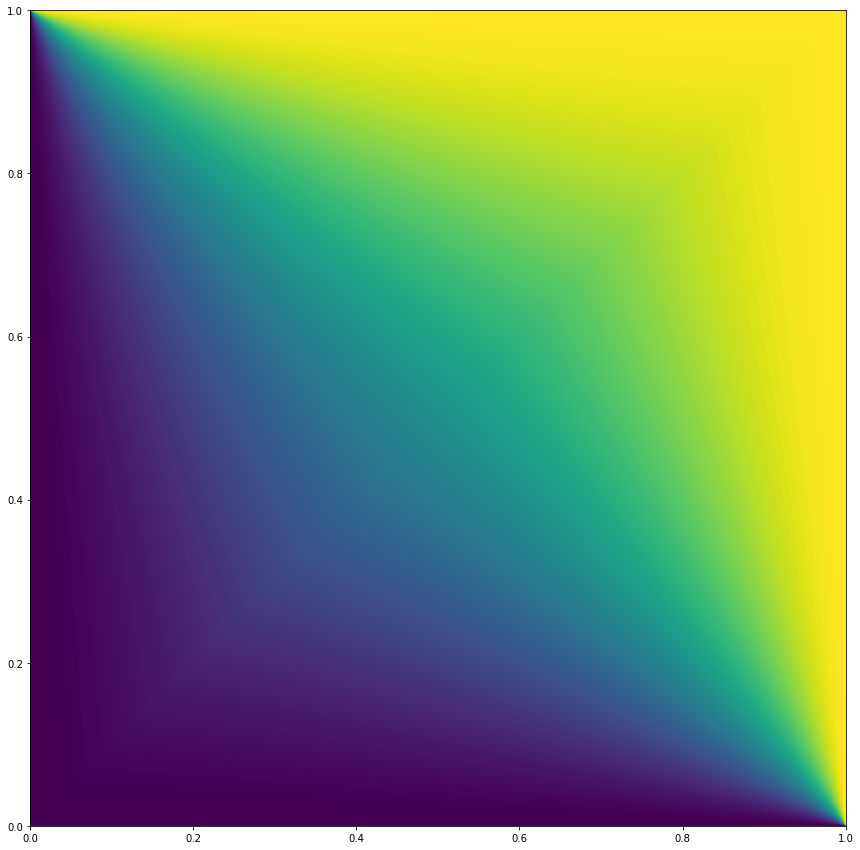

In [7]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(fs, origin="lower", extent=[0, 1, 0, 1])

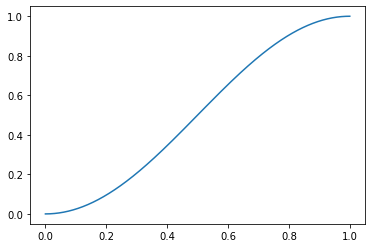

In [8]:
plt.plot(np.linspace(0, 1, len(np.diag(fs))), np.diag(fs))

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  after removing the cwd from sys.path.


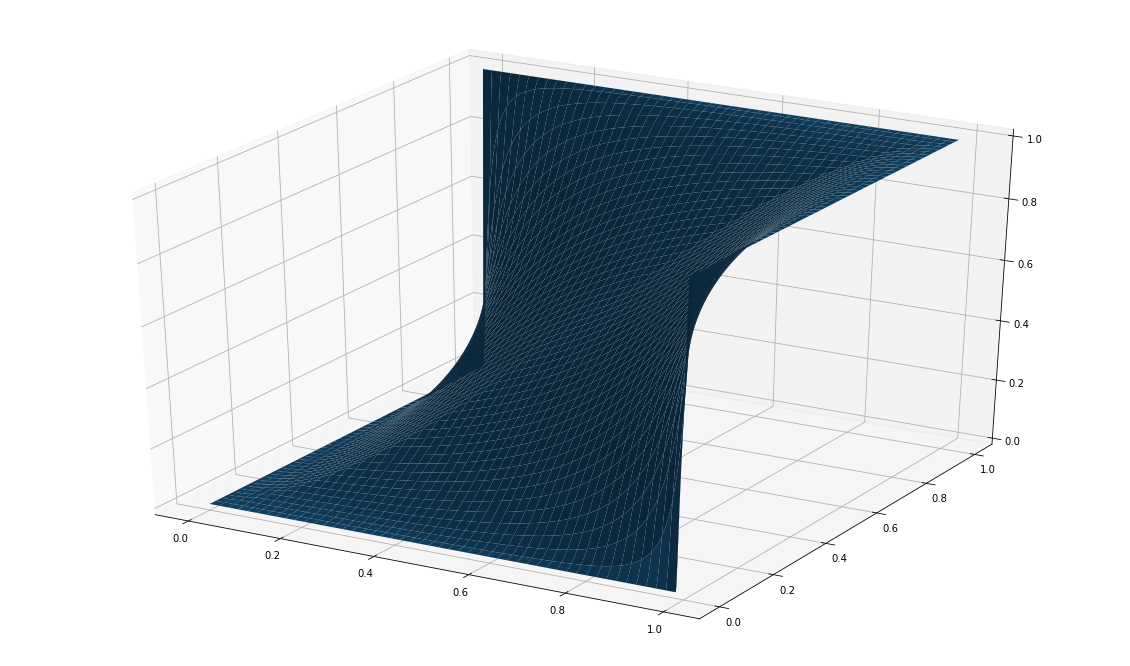

In [9]:
from mpl_toolkits.mplot3d import Axes3D
figure = plt.figure(figsize=(20, 12))
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(ss, qs, fs)

We notice that the function is not differentiable everywhere on the interior.

## A PDE solution

\begin{align}
p(s, q) = \sum_{n = 1}^\infty \frac{2(1 - (-1)^n)}{n \pi \sinh(n \pi)} (\sin(n \pi s) \sinh(n \pi q) + \sinh(n \pi s) \sin(n \pi q) )
\end{align}

In [10]:
from pde import p as probability, u, dpds as dprobability_ds, dpdq as dprobability_dq

Because the denominator in the fraction of the terms grows exponentially, we have a good approximation with 10 or so terms.

In [11]:
us = np.array([u(2 * n + 1, ss, qs) for n in range(10)])
ps = probability(ss, qs)

In [12]:
us.shape, ps.shape

((10, 2001, 2001), (2001, 2001))

### Is it close to the legacy sine function above?

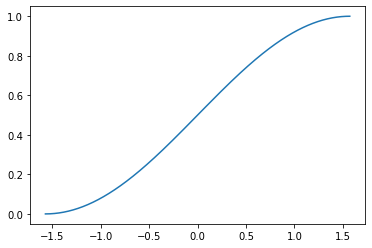

In [13]:
plt.close()
plt.plot(np.linspace(-pi / 2, pi / 2, ps.shape[-1]), .5 + .5 * np.sin(np.linspace(-pi / 2, pi / 2, ps.shape[-1])))
plt.show()

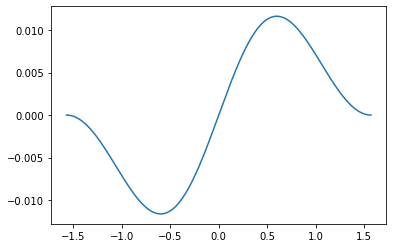

In [14]:
plt.close()
plt.plot(
    np.linspace(-pi / 2, pi / 2, ps.shape[-1]), 
    np.diag(ps) - (.5 + .5 * np.sin(np.linspace(-pi / 2, pi / 2, ps.shape[-1]))),
)
plt.show()

We conclude that it is close, but different.

### Demonstration of the term-by-term approximation

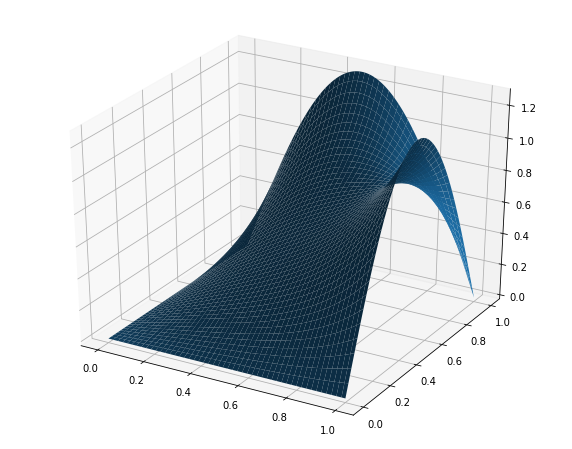

In [15]:
plt.close()
figure = plt.figure(figsize=(10, 8))
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(ss, qs, us[0])

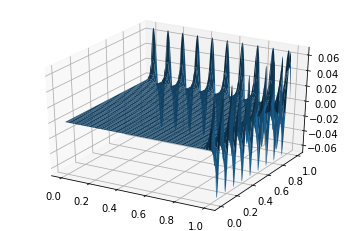

In [16]:
figure = plt.figure()
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(ss, qs, us[-1])

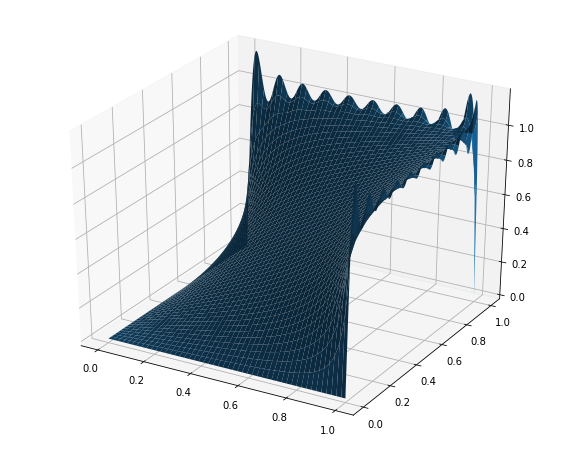

In [17]:
plt.close()
figure = plt.figure(figsize=(10, 8))
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(ss, qs, np.sum(us, axis=0))

In practice, we use the symmetry (or equivalently, a cosine approximation) to avoid numerical issues.

Evaluated with use of the symmetry, the probability function as used in the other documents looks as below.

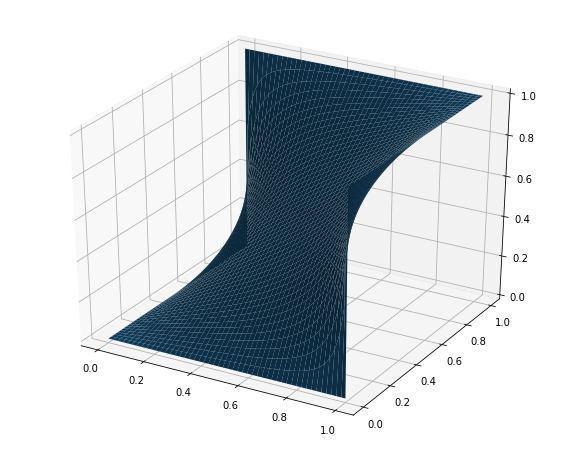

In [18]:
plt.close()
figure = plt.figure(figsize=(10, 8))
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(ss, qs, ps)

The function is not flat, which means that more of the surface will be used in the approximation.

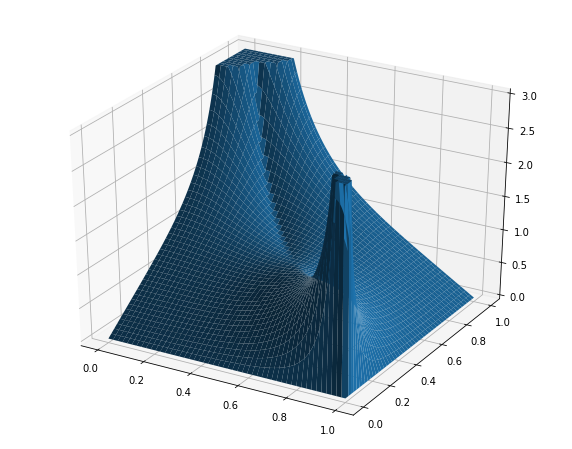

In [19]:
plt.close()
figure = plt.figure(figsize=(10, 8))
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(ss, qs, np.minimum(dprobability_ds(ss, qs), 3))

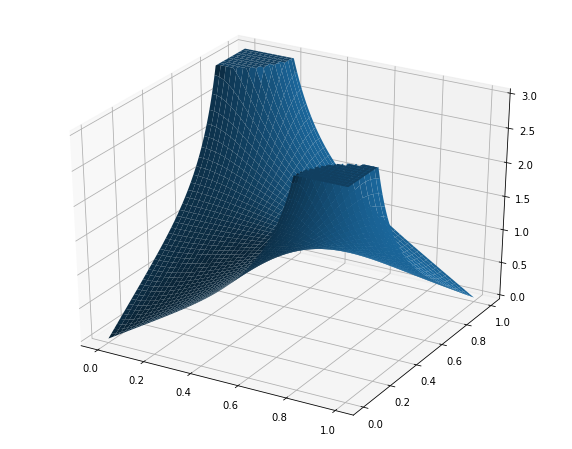

In [20]:
plt.close()
figure = plt.figure(figsize=(10, 8))
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(ss, qs, np.minimum(np.sqrt(dprobability_ds(ss, qs) ** 2 + dprobability_dq(ss, qs) ** 2), 3e0))

The function as heatmap.

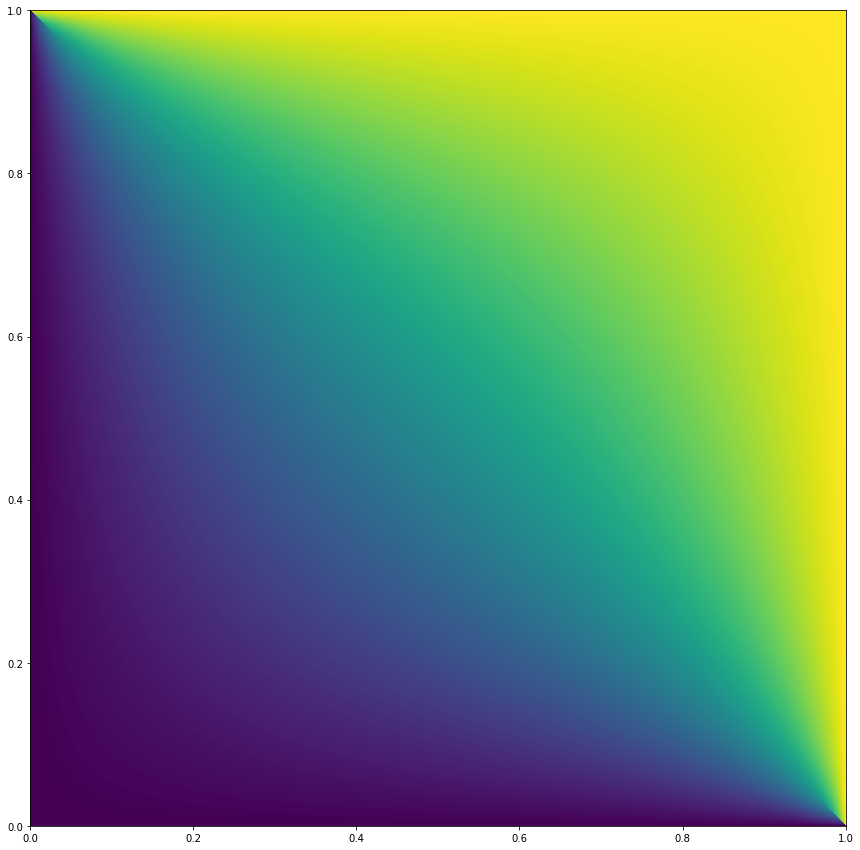

In [21]:
plt.close()
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(ps, origin="lower", extent=[0, 1, 0, 1])

The gradient as heatmap, clipped at 3.

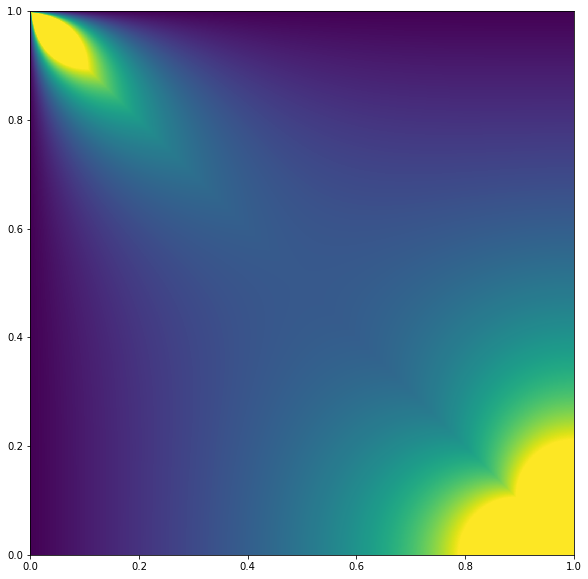

In [22]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.minimum(dprobability_ds(ss, qs), 3), origin="lower", extent=[0, 1, 0, 1])

### Bonus: small investigation of numerical approximation issues

In [23]:
from pde import duds

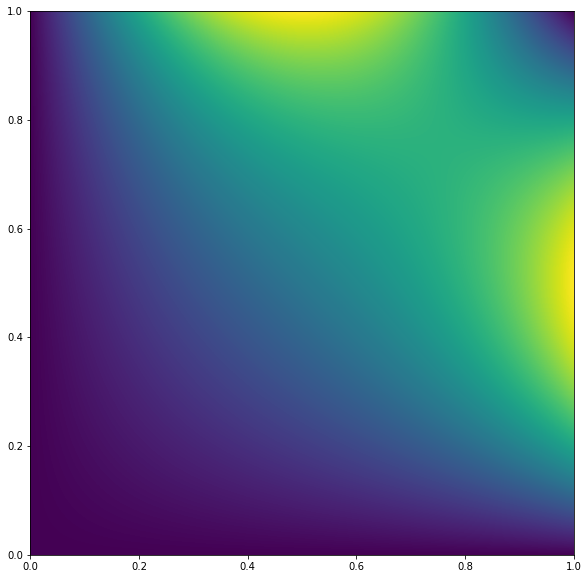

In [24]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(u(1, ss, qs), origin="lower", extent=[0, 1, 0, 1])

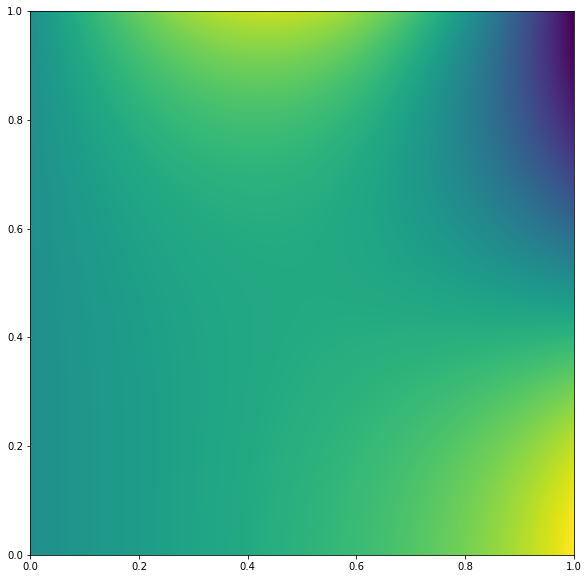

In [25]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(duds(1, ss, qs), origin="lower", extent=[0, 1, 0, 1])

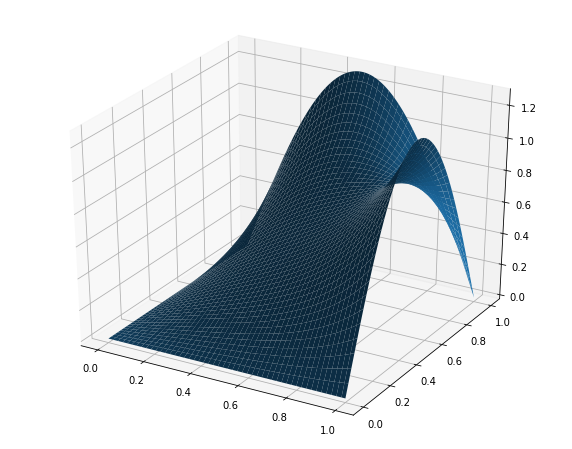

In [26]:
plt.close()
figure = plt.figure(figsize=(10, 8))
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(ss, qs, u(1, ss, qs))

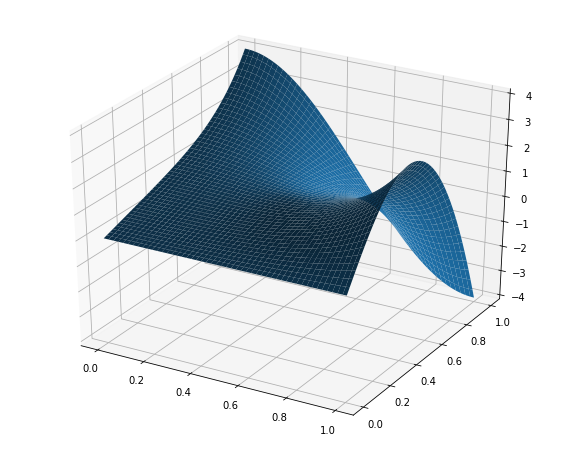

In [27]:
plt.close()
figure = plt.figure(figsize=(10, 8))
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(ss, qs, duds(1, ss, qs))

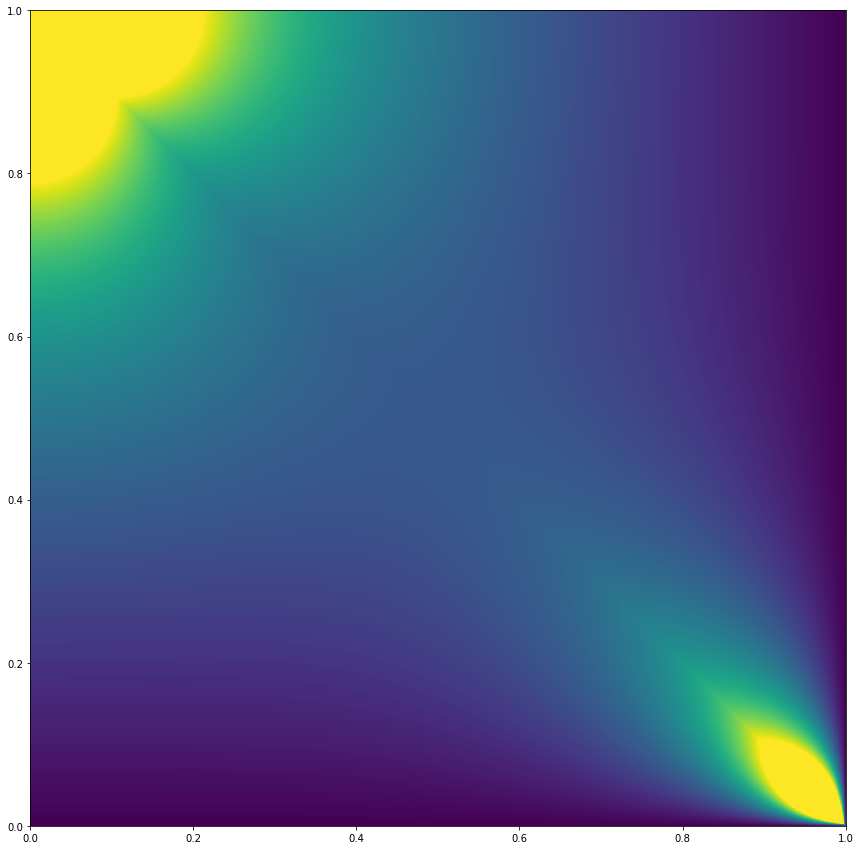

In [28]:
plt.close()
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(np.minimum(dprobability_dq(ss, qs), 3), origin="lower", extent=[0, 1, 0, 1])

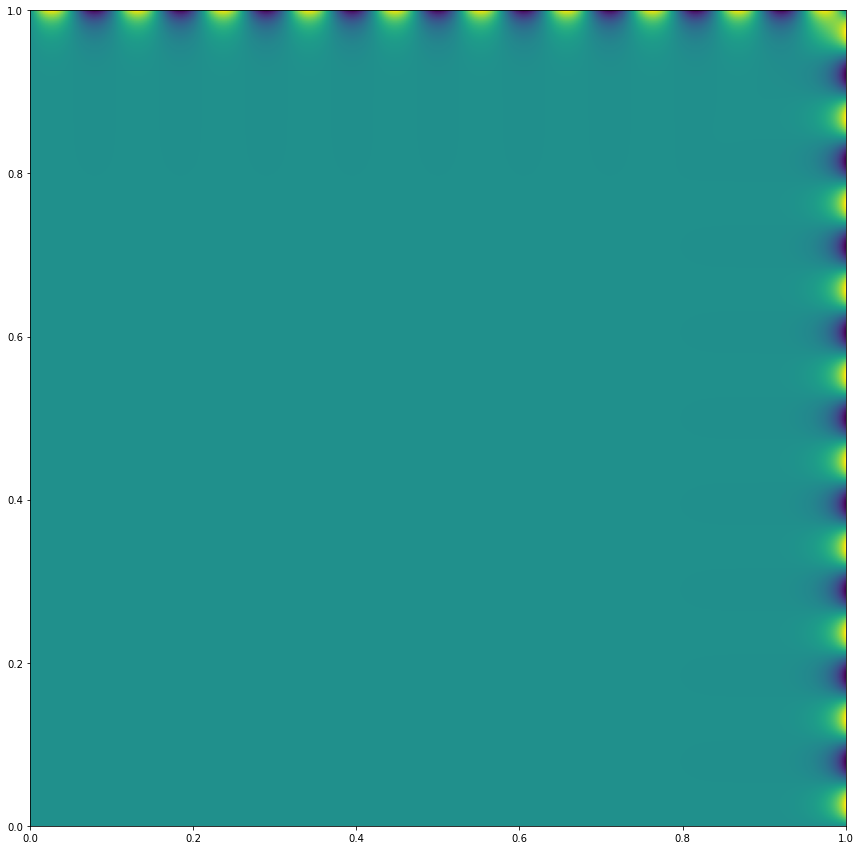

In [29]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(us[-1], origin="lower", extent=[0, 1, 0, 1])

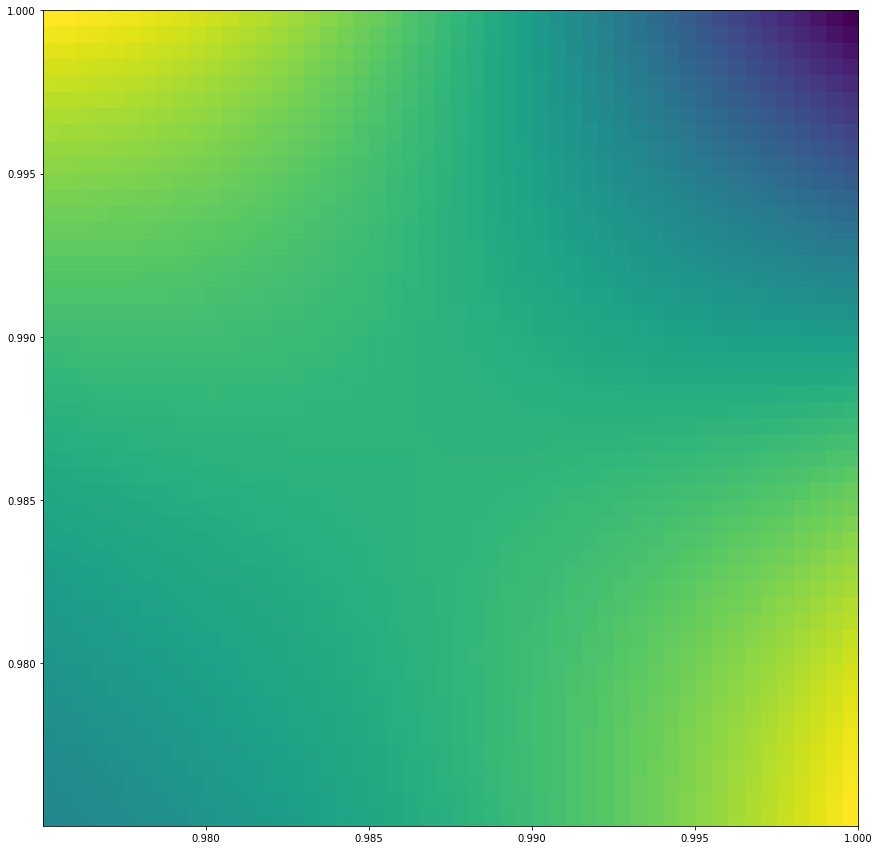

In [30]:
fig, ax = plt.subplots(figsize=(15, 15))
size = 50
ax.imshow(
    us[-1, us.shape[-2] - size:, us.shape[-1] - size:],
    origin="lower",
    extent=[(us.shape[-2] - size) / us.shape[-2], 1, (us.shape[-1] - size) / us.shape[-1], 1],
)

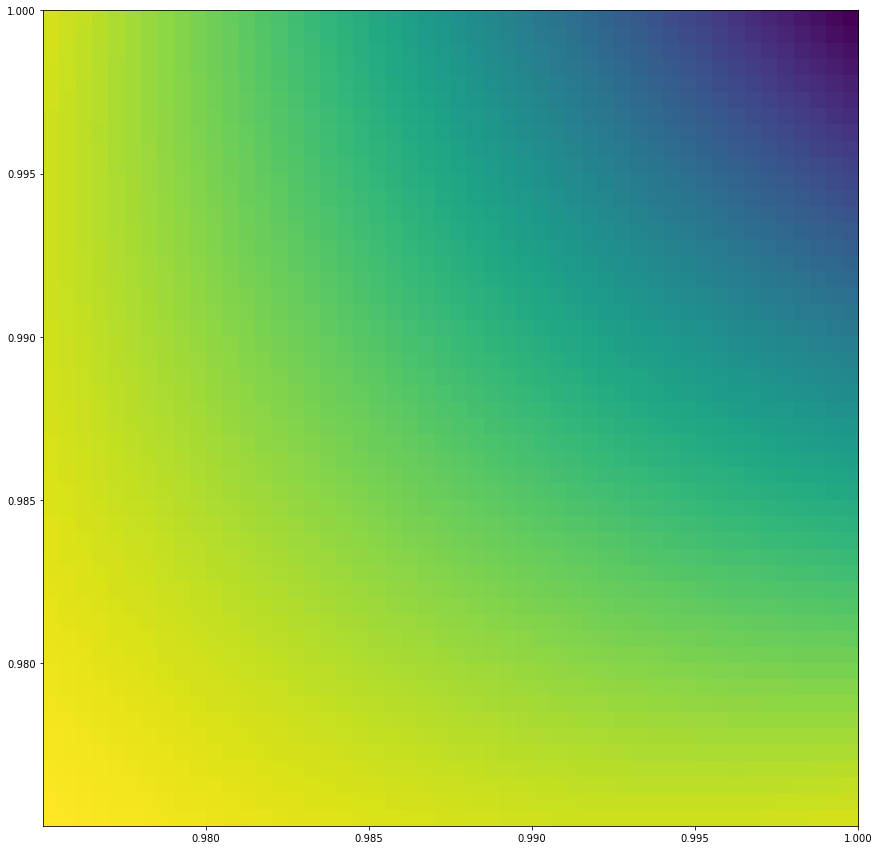

In [31]:
fig, ax = plt.subplots(figsize=(15, 15))
size = 50
ax.imshow(
    np.sum(us[:, us.shape[-2] - size:, us.shape[-1] - size:], axis=0),
    origin="lower",
    extent=[(us.shape[-2] - size) / us.shape[-2], 1, (us.shape[-1] - size) / us.shape[-1], 1],
)

In [32]:
np.sum(us[:, -2, -2])

0.03937603322740452

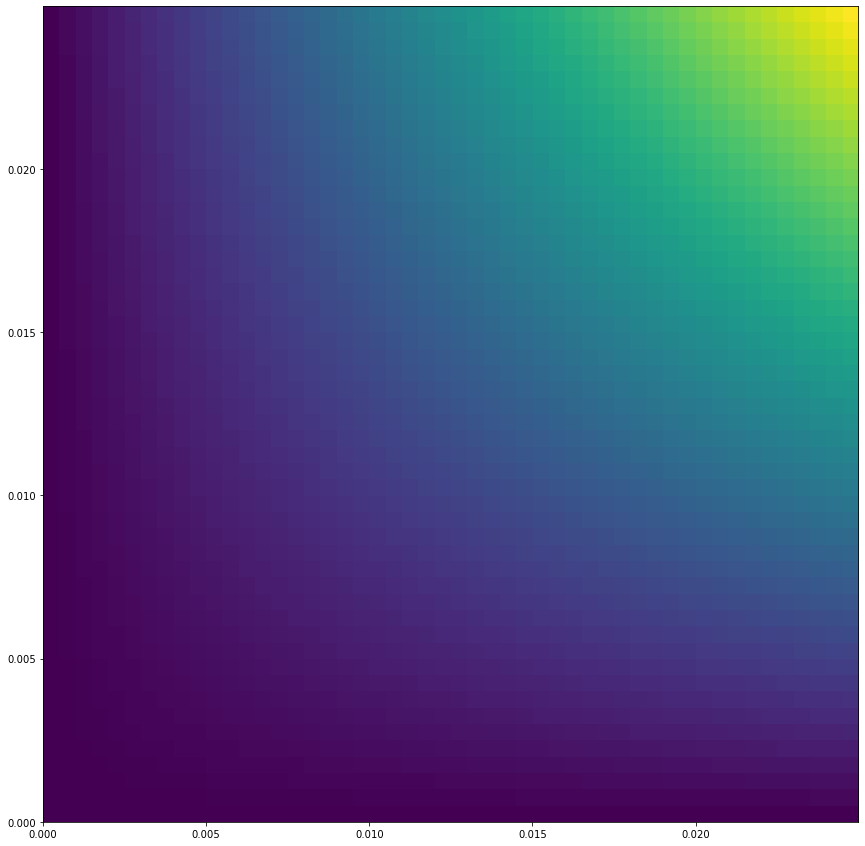

In [33]:
fig, ax = plt.subplots(figsize=(15, 15))
size = 50
ax.imshow(
    np.sum(us[:, :size, :size], axis=0),
    origin="lower",
    extent=[0, size / us.shape[-2], 0, size / us.shape[-1]],
)

In [34]:
np.sum(us[:, 0, 0]), np.sum(us[:, size, size])

(0.0, 0.0013677739176914969)